In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import math
from PIL import Image
torch.manual_seed(0)
print(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

cuda


In [10]:
class PoseDataset(Dataset):    
    def __init__(self, data_dir = None):
        self._data_dir = data_dir
        data_dirs = [x[0] for x in os.walk(self._data_dir)][1:]
        annotations = []
        for i in range(len(data_dirs)):
            data = json.load(open(f"{data_dirs[i]}/annotations.json"))
            annotation = data['annotations']
            img_dict = {}
            for name in data['images']:
                img_dict[name['id']] = name['file_name']
            for k in range(len(annotation)):
                annotation[k]['image_path'] = f"{data_dirs[i]}/{img_dict[annotation[k]['image_id']]}"
            annotations.extend(annotation)
        self._annotations_person = [ano for ano in annotations if ano['category_id'] == 0 and len(ano['keypoints'])==51]
        self._pose_dict = {"liftingbad": 0, 
                           "liftinggood": 1, 
                           "reachingbad": 2, 
                           "reachinggood": 3, 
                           'randomrandom': 3}

    def _process_pose(self, pose):
        return self._pose_dict[pose]
    
    def _get_pose_size(self, keypoints, ratio):
        hips_center = (keypoints[9,:] + keypoints[10,:]) / 2
        shoulders_center = (keypoints[3,:] + keypoints[4,:]) / 2
        torso_size = np.linalg.norm((shoulders_center - hips_center))
        distance = np.linalg.norm((keypoints - hips_center), axis = 1)
        max_d = np.max(distance)
        pose_size = max(torso_size * ratio, max_d)
        return pose_size
    def _normalize_pose(self,keypoints):
        data_p = np.expand_dims(np.array(keypoints), axis=1).reshape(-1,3)[:,0:2]
        confidence = np.expand_dims(np.array(keypoints), axis=1).reshape(-1,3)[:,2]
        confidence = np.expand_dims(np.delete(confidence,[3,4]), axis = 1)
        data_p = np.delete(data_p,[3,4], axis = 0)
        hip_center = (data_p[9,:] + data_p[10,:]) / 2
        data_p = data_p - hip_center
        pose_size = self._get_pose_size(data_p, 2)
        data_p = data_p / pose_size
        data_p = np.hstack((data_p,confidence))
        return data_p.flatten()
    def __getitem__(self, idx):
        actor = self._annotations_person[idx]
        if actor['keypoints'] is None:
            print("is None")
        x = torch.tensor(self._normalize_pose(actor['keypoints']))
        pose = actor['pose_category'] + actor['pose_subcategory']
        y = self._process_pose(pose)
        return x, y, actor['image_path'], np.array(actor['bbox'])
    def __len__(self):
        return len(self._annotations_person)

In [3]:
pose_data = PoseDataset(data_dir = '/home/reza_voxelsafety_com/experiments/ergonomic/ergonomic-Infinity-occlusion/')

In [4]:
print(len(pose_data))

299380


In [5]:
num_val= int(len(pose_data) * 0.1)
num_train = len(pose_data) - 2 * num_val
train, val, test = random_split(pose_data, [num_train, num_val, num_val])
batch_size = 128
dataloaders = {
    'train': DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8),
    'val': DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8),
}
dataset_sizes = {}
dataset_sizes['train'] = len(train)
dataset_sizes['val'] = len(val)
dataset_sizes['test'] = len(test)
print(dataset_sizes)

{'train': 239504, 'val': 29938, 'test': 29938}


In [29]:
dataloader_test = DataLoader(train, batch_size=1, shuffle=False)
x, y, z, w = next(iter(dataloader_test))
print(f"size of one batch input data {x.shape}")
print(f"size of one batch label data {y.shape}")
print(f"size of one batch image data {z}")
print(f"size of one batch image data {w}")

(15, 2)
(15, 1)
size of one batch input data torch.Size([1, 45])
size of one batch label data torch.Size([1])
size of one batch image data ('/home/reza_voxelsafety_com/experiments/ergonomic/ergonomic-Infinity-occlusion/_americold-savannah-bloomingdale-0002/image.000000.rgb.png',)
size of one batch image data tensor([[876.0100, 411.0100,  50.9800, 103.9800]], dtype=torch.float64)


In [15]:
print(f"number of datapoints: {len(pose_data)}")

number of datapoints: 299380


In [6]:
from torch import nn
class PoseModel(nn.Module):
    
    def __init__(self, input_size, num_classes):
        super(PoseModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        y = x.clone().detach()
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x, y

In [7]:
from torch import nn
import wandb
from torch.optim import lr_scheduler
import time
import copy
from datetime import datetime


def train_model(model, dataloaders, dataset_sizes, optimizer, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    wandb.init(project =  "ergo_ml_training", entity = "voxel-wandb", config = config, tags = [config['tags']])
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=0.1)
    config = wandb.config
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())   
    best_accuracy = 0
    model.to(device)
    today_date = datetime.today().strftime('%Y-%m-%d')
    for epoch in range(config.num_epochs):
        print('Epoch {}/{}'.format(epoch, config.num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels, _, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, y = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            if phase == 'train':
                scheduler.step()
                
            if phase == 'val':
                #print("val accuracy", epoch_acc)
                wandb.log({"val loss":epoch_loss})
                wandb.log({"val_accuracy":epoch_acc})
            if phase == 'train':
                #print("train accuracy", epoch_acc)
                #print("train loss", epoch_loss)
                wandb.log({"train loss":epoch_loss})
                wandb.log({"train_accuracy":epoch_acc})
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_accuracy))

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f"voxel_ergo_ml_{config.tags}_{today_date}.pth")
    wandb.join()
    return model
    

In [8]:
config = {
        'num_epochs': 100,
        'tags': "ergoMLLinearAlphaPoseModelOcclusion",
        'step': 70,
}
pose_model = PoseModel(45,4)
optimizer = torch.optim.SGD(pose_model.parameters(), lr=0.1, momentum=0.9)
train_model(pose_model, dataloaders, dataset_sizes, optimizer, config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: voxel-wandb (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-05-20 22:35:47.077628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 22:35:47.077671: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 0/99
----------
train Loss: 1.0671208252990578 Acc: 0.6764479925178704
val Loss: 0.9888864889819586 Acc: 0.7539247778742736
Epoch 1/99
----------
train Loss: 1.005391214827082 Acc: 0.7376453002872604
val Loss: 0.9849732558134284 Acc: 0.757732647471441
Epoch 2/99
----------
train Loss: 0.9977447608683294 Acc: 0.7450397488142161
val Loss: 0.978125858349889 Acc: 0.7645133275435901
Epoch 3/99
----------
train Loss: 0.9923392267789095 Acc: 0.750597067272363
val Loss: 0.9842729127329826 Acc: 0.7583672924043022
Epoch 4/99
----------
train Loss: 0.9894386186844377 Acc: 0.7533569376711872
val Loss: 0.9707516314860886 Acc: 0.7725966998463492
Epoch 5/99
----------
train Loss: 0.9867877218541564 Acc: 0.7559873739060726
val Loss: 0.970629280244542 Acc: 0.7721624691028125
Epoch 6/99
----------
train Loss: 0.9849963537700127 Acc: 0.7578161533836596
val Loss: 0.9688647740812146 Acc: 0.7740664039013962
Epoch 7/99
----------
train Loss: 0.982846961776227 Acc: 0.7599413788496227
val Loss: 0.9654689

train Loss: 0.9657284839970848 Acc: 0.777444218050638
val Loss: 0.9557352306067295 Acc: 0.7875609593159196
Epoch 64/99
----------
train Loss: 0.9674290094739394 Acc: 0.7757866256930991
val Loss: 0.9532911730032422 Acc: 0.7902331485069143
Epoch 65/99
----------
train Loss: 0.9657404695757167 Acc: 0.7774233415725834
val Loss: 0.9512793098417278 Acc: 0.7920034738459484
Epoch 66/99
----------
train Loss: 0.963381338723955 Acc: 0.7798742400961989
val Loss: 0.9508335557751015 Acc: 0.7923374974948226
Epoch 67/99
----------
train Loss: 0.9651089916408273 Acc: 0.7779828311844479
val Loss: 0.9547607300634956 Acc: 0.7882958113434432
Epoch 68/99
----------
train Loss: 0.964041876338178 Acc: 0.7791602645467299
val Loss: 0.9500420862276622 Acc: 0.7933395684414457
Epoch 69/99
----------
train Loss: 0.9637168111252604 Acc: 0.7794734117175497
val Loss: 0.9549528444304687 Acc: 0.7879617876945688
Epoch 70/99
----------
train Loss: 0.9598151000056209 Acc: 0.7834524684347652
val Loss: 0.9487427176418759 Ac

train loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
val loss,█▆▅▄▄▄▄▃▃▃▄▃▃▂▃▂▂▂▂▂▂▂▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▅▆▆▆▅▆▆▇▆▇▇▇▆▇▇▇▆▇▇▆▇▇████████████
train loss,0.95167
train_accuracy,0.79161
val loss,0.94506
val_accuracy,0.79842


PoseModel(
  (layer1): Linear(in_features=45, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [11]:
pose_data_real = PoseDataset(data_dir = '/home/reza_voxelsafety_com/experiments/ergonomic/realdata_kp/')
print(len(pose_data_real))

5455


wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-05-20 23:05:46.515568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 23:05:46.515616: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (5).

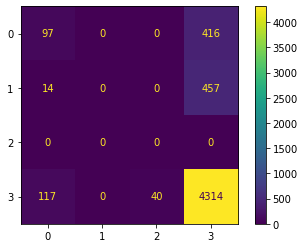

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
wandb.init(
            project="ergo_synthetic_test",
            job_type="inference",
            entity="voxel-wandb",
        )
TEST_TABLE_NAME = "test_results"
columns = ["Images", "Prediction", "GT"]
labels_type= ["liftingbad", "liftinggood", "reachingbad",'randomrandom']
for klass in labels_type:
    columns.append("score_" + klass)
test_dt = wandb.Table(columns=columns)
model = PoseModel(45, 4)
model.load_state_dict(
    torch.load('/home/reza_voxelsafety_com/voxel/experimental/reza/Ergonomic/voxel_ergo_ml_ergoMLLinearAlphaPoseModelOcclusion_2022-05-20.pth')
)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloaders['test'] = DataLoader(pose_data_real, batch_size=1, shuffle=False, num_workers=8)
running_corrects = 0
model.to(device)
y_true = []
y_pred = []
for inputs, labels, path, bbox in dataloaders['test']:
    bbox = bbox.tolist()[0]
    image = Image.open(path[0])
    image = image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs,_ = model(inputs.float())
    _, preds = torch.max(outputs, 1)
    y_pred.append(preds.item())
    y_true.append(labels.item())
    row = [wandb.Image(image),
            labels_type[preds], labels_type[labels]]
    for c_i in outputs.data.cpu().numpy().tolist():
        for c in c_i:
            row.append(np.round(c, 4))
    test_dt.add_data(*row)
    running_corrects += torch.sum(preds == labels.data)

label_mapping = {
    "liftingbad": 0, 
   "liftinggood": 1, 
   "reachingbad": 2, 
   "reachinggood": 3, 
   'randomrandom': 4
}
target_names = list(label_mapping.keys())

cm = confusion_matrix(y_pred,y_true)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45)
wandb.sklearn.plot_confusion_matrix(y_true, y_pred, target_names)
wandb.log({TEST_TABLE_NAME: test_dt})
accuracy_test = running_corrects.double() / len(pose_data_real)
print(f"Accuracy test {accuracy_test}")

In [32]:
accuracy_test = running_corrects.double() / len(pose_data_real)
print(f"Accuracy test {accuracy_test}")

Accuracy test 0.6892758936755271


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  liftingbad       0.16      0.45      0.24       228
 liftinggood       0.00      0.00      0.00         0
 reachingbad       0.14      0.38      0.21        40
reachinggood       0.17      0.04      0.07      1189
randomrandom       0.79      0.79      0.79      3998

    accuracy                           0.61      5455
   macro avg       0.25      0.33      0.26      5455
weighted avg       0.62      0.61      0.60      5455



/home/reza_voxelsafety_com/.cache/bazel/_bazel_reza_voxelsafety_com/d620f0b6d4b41da06538aa48e57dfab6/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_scikit_learn/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reza_voxelsafety_com/.cache/bazel/_bazel_reza_voxelsafety_com/d620f0b6d4b41da06538aa48e57dfab6/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_scikit_learn/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reza_voxelsafety_com/.cache/bazel/_bazel_reza_voxelsafety_com/

In [14]:
import functools
import os.path
import random
import sys
import xml.etree.ElementTree
import numpy as np
import matplotlib.pyplot as plt
import skimage.data
import cv2
import PIL.Image

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.
